# Sentiment Analysis with an RNN

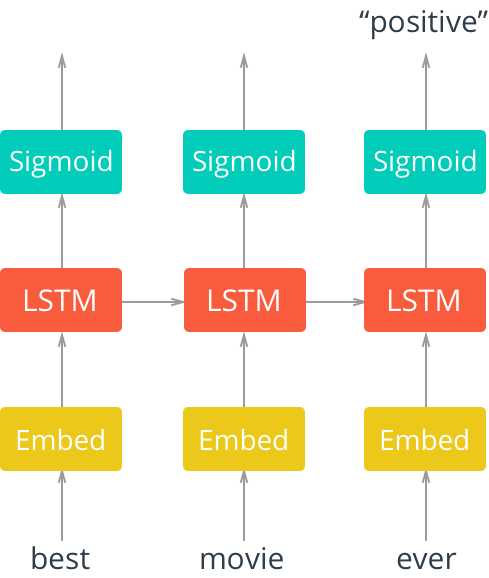

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Loading the data and visualization

In [2]:
with open(r'../input/imdb-dataset/reviews.txt','r') as f:
    reviews = f.read()
with open(r'../input/imdb-dataset/labels.txt','r') as f:
    labels = f.read() 

In [3]:
print('REVIEWS')
print(reviews[0:1000])
print('LABELS')
print(labels[0:10])

REVIEWS
bromwell high is a cartoon comedy . it ran at the same time as some other programs about school life  such as  teachers  . my   years in the teaching profession lead me to believe that bromwell high  s satire is much closer to reality than is  teachers  . the scramble to survive financially  the insightful students who can see right through their pathetic teachers  pomp  the pettiness of the whole situation  all remind me of the schools i knew and their students . when i saw the episode in which a student repeatedly tried to burn down the school  i immediately recalled . . . . . . . . . at . . . . . . . . . . high . a classic line inspector i  m here to sack one of your teachers . student welcome to bromwell high . i expect that many adults of my age think that bromwell high is far fetched . what a pity that it isn  t   
story of a man who has unnatural feelings for a pig . starts out with a opening scene that is a terrific example of absurd comedy . a formal orchestra audience

## Data Preprocessing

In [4]:
from string import punctuation

print(f'Punctuations: {punctuation}')
reviews = reviews.lower()
all_text = ''.join([c for c in reviews if c not in punctuation])
reviews_split = all_text.split('\n')
all_text = ' '.join(reviews_split)
words = all_text.split()
print(words[0:10])

Punctuations: !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
['bromwell', 'high', 'is', 'a', 'cartoon', 'comedy', 'it', 'ran', 'at', 'the']


## Encoding the words

In [5]:
from collections import Counter # multiset equivalent that stores key and count

counts = Counter(words)
# Most frequent words get initial indices
vocab = sorted(counts, key = counts.get, reverse = True)
# print(vocab)
vocab_to_int  = {word:idx for idx, word in enumerate(vocab, 1)}
# print(vocab_to_int)
reviews_ints = []
for review in reviews_split:
    reviews_ints.append([vocab_to_int[word] for word in review.split()])

In [6]:
# Dictionary
# print(counts.items())
# Frequency
# print(counts.get('a'))
# print(reviews_ints[0])

## Encoding the labels

In [7]:
labels_split = labels.split('\n')
encoded_labels = np.array([1 if label=='positive' else 0 for label in labels_split])
print(encoded_labels)

[1 0 1 ... 1 0 0]


## Removing outliers

1. Get rid of extremely short or long texts
1. Padding/truncating the remaining data so that we have reviews of the same length.

In [8]:
review_lens = Counter([len(x) for x in reviews_ints])
print("Zero-length reviews: {}".format(review_lens[0]))
print("Maximum review length: {}".format(max(review_lens)))

Zero-length reviews: 1
Maximum review length: 2514


In [9]:
non_zero_idx = [idx for idx,review in enumerate(reviews_ints) if len(review)!= 0]
print(len(non_zero_idx))

25000


In [10]:
reviews_ints = [reviews_ints[idx] for idx in non_zero_idx]
encoded_labels = np.array([encoded_labels[idx] for idx in non_zero_idx])
assert len(reviews_ints) == 25000

## Padding sequences

For example, if the seq_length=10 and an input review is:

[117, 18, 128]
The resultant, padded sequence should be:

[0, 0, 0, 0, 0, 0, 0, 117, 18, 128]

Our final features array will be a 2D array, with as many rows as there are reviews, and as many columns as the specified seq_length.

In [11]:
def pad_features(reviews_ints, seq_length):
    features = np.zeros((len(reviews_ints),seq_length), dtype = int)
    for idx,x in enumerate(reviews_ints):
        if len(x) < seq_length:
            features[idx,seq_length-len(x):] = x
        elif len(x) > seq_length:
            features[idx,:] = x[0:seq_length]
    return features

In [12]:
seq_length = 200

features = pad_features(reviews_ints, seq_length=seq_length)

assert len(features)==len(reviews_ints), "Features should have as many rows as reviews."
assert len(features[0])==seq_length, 'Features should have as many columns as seq_length'

# print first 10 values of the first 30 batches 
print(features[:30,:10])

[[    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]
 [22382    42 46418    15   706 17139  3389    47    77    35]
 [ 4505   505    15     3  3342   162  8312  1652     6  4819]
 [    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]
 [   54    10    14   116    60   798   552    71   364     5]
 [    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]
 [    1   330   578    34     3   162   748  2731     9   325]
 [    9    11 10171  5305  1946   689   444    22   280   673]
 [    0     0     0     0     0     0     0     0     0

## Training, Validation, Test

In [13]:
split_frac = 0.8

split_idx = int(len(features)*split_frac)
train_x, remaining_x = features[:split_idx], features[split_idx:]
train_y, remaining_y = encoded_labels[:split_idx], encoded_labels[split_idx:]

test_idx = int(len(remaining_x)*0.5)
val_x, test_x = remaining_x[:test_idx], remaining_x[test_idx:]
val_y, test_y = remaining_y[:test_idx], remaining_y[test_idx:]

print("\t\t\tFeature Shapes:")
print("Train set: \t\t{}".format(train_x.shape), 
      "\nValidation set: \t{}".format(val_x.shape),
      "\nTest set: \t\t{}".format(test_x.shape))

			Feature Shapes:
Train set: 		(20000, 200) 
Validation set: 	(2500, 200) 
Test set: 		(2500, 200)


In [14]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# First dimension of both features and labels must be same.
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
valid_data = TensorDataset(torch.from_numpy(val_x), torch.from_numpy(val_y))
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))

batch_size = 50

train_loader = DataLoader(train_data, shuffle = True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle = True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle = True, batch_size=batch_size)

In [15]:
dataiter = iter(train_loader)
sample_x, sample_y = dataiter.next()

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print()
print('Sample label size: ', sample_y.size()) # batch_size
print('Sample label: \n', sample_y)

Sample input size:  torch.Size([50, 200])
Sample input: 
 tensor([[    0,     0,     0,  ...,     1, 10456,   511],
        [    0,     0,     0,  ...,     4,     1,  3170],
        [    0,     0,     0,  ...,    85,   529, 67049],
        ...,
        [44458,    46,   251,  ...,   834,    87,   182],
        [    0,     0,     0,  ...,     7,    85,    18],
        [   49,   164,  1788,  ...,    12,    25,   151]])

Sample label size:  torch.Size([50])
Sample label: 
 tensor([1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0,
        0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0,
        1, 0])


## Sentiment Network with PyTorch

**Below is where we will define the network.**

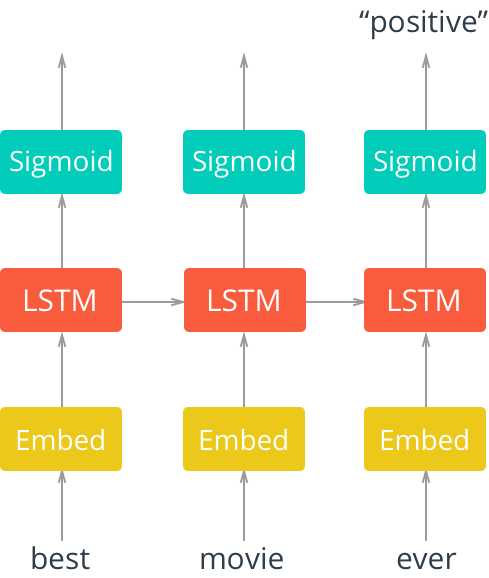

In [16]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [17]:
import torch.nn as nn

class SentimentRNN(nn.Module):
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob = 0.5):
        super().__init__()
        
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        self.embedding = nn.Embedding(num_embeddings = vocab_size, embedding_dim = embedding_dim)
        self.lstm = nn.LSTM(input_size = embedding_dim, hidden_size = hidden_dim, num_layers = n_layers, dropout = drop_prob, batch_first = True)
        
        self.dropout = nn.Dropout(p = drop_prob)
        self.fc1 = nn.Linear(in_features = hidden_dim, out_features = output_size)
        self.sig = nn.Sigmoid()
    
    def forward(self, X, Hidden):
        """
        Shape of X will be (batch_size, seq_length)
        
        Shape of embeds will be (batch_size, seq_length, embedding_dim)
        
        Shape of lstm_out will be (batch_size, seq_length, hidden_dim)
        and after taking last time-stamp it will be (batch_size, hidden_dim)
        
        Shape of hidden will be (num_layers, batch_size, hidden_dim)

        Shape of out will be (batch_size, 1)
        """
        batch_size = X.size(0)
        
        X = X.long()
        embeds = self.embedding(X)
        lstm_out, Hidden = self.lstm(embeds, Hidden)
        
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        
        # dropout and fully-connected layer
        out = self.dropout(lstm_out)
        out = self.fc1(out)
        
        # sigmoid function
        sig_out = self.sig(out)
        
        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1] # get last batch of labels
        
        # return last sigmoid output and hidden state
        return sig_out, Hidden
    
    def init_hidden(self, batch_size):
        # initialized to zero, for hidden state and cell state of LSTM
        
        weight = next(self.parameters()).data
        
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))
        
        return hidden

In [18]:
vocab_size = len(vocab_to_int) + 1 # +1 for the 0 padding + our word tokens
output_size = 1
embedding_dim = 400
hidden_dim = 256
n_layers = 2

net = SentimentRNN(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)
net.to(device)

print(net)

SentimentRNN(
  (embedding): Embedding(74073, 400)
  (lstm): LSTM(400, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


## Training

In [19]:
lr=0.001
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

In [20]:
epochs = 4 # 3-4 is approx where I noticed the validation loss stop decreasing

counter = 0
print_every = 100
clip = 5 # gradient clipping

net.train()
for e in range(epochs):
    # initialize hidden state
    h = net.init_hidden(batch_size)

    # batch loop
    for inputs, labels in train_loader:
        counter += 1

        inputs, labels = inputs.to(device), labels.to(device)

        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])

        # zero accumulated gradients
        net.zero_grad()

        # get the output from the model
        output, h = net(inputs, h)

        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        
        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(net.parameters(), clip)
        optimizer.step()

        # loss stats
        if counter % print_every == 0:
            # Get validation loss
            val_h = net.init_hidden(batch_size)
            val_losses = []
            net.eval()
            for inputs, labels in valid_loader:

                # Creating new variables for the hidden state, otherwise
                # we'd backprop through the entire training history
                val_h = tuple([each.data for each in val_h])
                
                
                inputs, labels = inputs.to(device), labels.to(device)

                output, val_h = net(inputs, val_h)
                val_loss = criterion(output.squeeze(), labels.float())

                val_losses.append(val_loss.item())

            net.train()
            print("Epoch: {}/{}...".format(e+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)))

Epoch: 1/4... Step: 100... Loss: 0.617334... Val Loss: 0.639917
Epoch: 1/4... Step: 200... Loss: 0.715689... Val Loss: 0.662513
Epoch: 1/4... Step: 300... Loss: 0.675946... Val Loss: 0.609824
Epoch: 1/4... Step: 400... Loss: 0.524795... Val Loss: 0.602445
Epoch: 2/4... Step: 500... Loss: 0.764917... Val Loss: 0.683677
Epoch: 2/4... Step: 600... Loss: 0.462383... Val Loss: 0.543032
Epoch: 2/4... Step: 700... Loss: 0.512918... Val Loss: 0.487150
Epoch: 2/4... Step: 800... Loss: 0.475844... Val Loss: 0.475181
Epoch: 3/4... Step: 900... Loss: 0.394391... Val Loss: 0.475314
Epoch: 3/4... Step: 1000... Loss: 0.495752... Val Loss: 0.500235
Epoch: 3/4... Step: 1100... Loss: 0.482862... Val Loss: 0.504265
Epoch: 3/4... Step: 1200... Loss: 0.360852... Val Loss: 0.463877
Epoch: 4/4... Step: 1300... Loss: 0.131148... Val Loss: 0.524755
Epoch: 4/4... Step: 1400... Loss: 0.230714... Val Loss: 0.505764
Epoch: 4/4... Step: 1500... Loss: 0.220144... Val Loss: 0.466616
Epoch: 4/4... Step: 1600... Loss: 

## Testing

In [21]:
test_losses = [] # track loss
num_correct = 0

# init hidden state
h = net.init_hidden(batch_size)

net.eval()
# iterate over test data
for inputs, labels in test_loader:

    # Creating new variables for the hidden state, otherwise
    # we'd backprop through the entire training history
    h = tuple([each.data for each in h])
    
    inputs, labels = inputs.to(device), labels.to(device)
    
    # get predicted outputs
    output, h = net(inputs, h)
    
    # calculate loss
    test_loss = criterion(output.squeeze(), labels.float())
    test_losses.append(test_loss.item())
    
    # convert output probabilities to predicted class (0 or 1)
    pred = torch.round(output.squeeze())  # rounds to the nearest integer
    
    # compare predictions to true label
    correct_tensor = pred.eq(labels.float().view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    num_correct += np.sum(correct)


# -- stats! -- ##
# avg test loss
print("Test loss: {:.3f}".format(np.mean(test_losses)))

# accuracy over all test data
test_acc = num_correct/len(test_loader.dataset)
print("Test accuracy: {:.3f}".format(test_acc))

Test loss: 0.477
Test accuracy: 0.796


## Inference on a test review

In [22]:
test_review_neg = 'The worst movie I have seen; acting was terrible and I want my money back. This movie had bad acting and the dialogue was slow.'
print(test_review_neg)

The worst movie I have seen; acting was terrible and I want my money back. This movie had bad acting and the dialogue was slow.


In [23]:
from string import punctuation

def tokenize_review(test_review):
    test_review = test_review.lower()
    test_text = ''.join([c for c in test_review if c not in punctuation])
    test_words = test_text.split()
    test_ints = []
    test_ints.append([vocab_to_int[word] for word in test_words])
    return test_ints

test_ints = tokenize_review(test_review_neg)
print(test_ints)

[[1, 247, 18, 10, 28, 108, 113, 14, 388, 2, 10, 181, 60, 273, 144, 11, 18, 68, 76, 113, 2, 1, 410, 14, 539]]


In [24]:
seq_length=200
features = pad_features(test_ints, seq_length)

print(features)

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   1 247  18  10  28
  108 113  14 388   2  10 181  60 273 144  11  18  68  76 113   2   1 410
   14 539]]


In [25]:
feature_tensor = torch.from_numpy(features)
print(feature_tensor.size())

torch.Size([1, 200])


In [26]:
def predict(net, test_review, sequence_length=200):
    
    net.eval()
    
    # tokenize review
    test_ints = tokenize_review(test_review)
    
    # pad tokenized sequence
    seq_length = sequence_length
    features = pad_features(test_ints, seq_length)
    
    # convert to tensor to pass into your model
    feature_tensor = torch.from_numpy(features)
    
    batch_size = feature_tensor.size(0)
    
    # initialize hidden state
    h = net.init_hidden(batch_size)
    
    feature_tensor = feature_tensor.to(device)
    
    # get the output from the model
    output, h = net(feature_tensor, h)
    
    # convert output probabilities to predicted class (0 or 1)
    pred = torch.round(output.squeeze()) 
    # printing output value, before rounding
    print('Prediction value, pre-rounding: {:.6f}'.format(output.item()))
    
    # print custom response
    if(pred.item()==1):
        print("Positive review detected!")
    else:
        print("Negative review detected.")

In [27]:
test_review_pos = 'This movie had the best acting and the dialogue was so good. I loved it.'
print(test_review_pos)

This movie had the best acting and the dialogue was so good. I loved it.


In [28]:
seq_length=200 # good to use the length that was trained on

predict(net, test_review_neg, seq_length)

Prediction value, pre-rounding: 0.025929
Negative review detected.


In [29]:
predict(net, test_review_pos, seq_length)

Prediction value, pre-rounding: 0.895679
Positive review detected!


In [30]:
my_review = "I am happy that I didn't saw this movie."

In [31]:
predict(net, my_review, seq_length)

Prediction value, pre-rounding: 0.817032
Positive review detected!
